# **Fixed Binning - Separated in Consecutive Bins**

In [36]:
import pandas as pd
import ace_tools_open as tools
import numpy as np
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('./products_to_package.csv')
df

,set,strike,notional
0,0,1.0035,1660000.0
1,0,1.0037,3480000.0
2,0,1.0054,450000.0
3,0,1.0077,460000.0
4,0,1.0095,1470000.0
...,...,...,...
396,9,1.0941,680000.0
397,9,1.0959,2470000.0
398,9,1.0963,470000.0
399,9,1.0969,390000.0


In [38]:
def fixed_cost(nominal):
    return 0.0006 * nominal if nominal <= 1_000_000 else 0.0003 * nominal

def curve_cost(nominal):
    return (11 - 0.5 * np.log(nominal)) / 10000 * nominal

In [39]:
def calculate_individual_cost(final_df):
    set_data = final_df.copy()
    set_data["fixed_cost"] = set_data["notional"].apply(fixed_cost)
    set_data["curve_cost"] = set_data["notional"].apply(curve_cost)
    set_data = set_data.groupby("set")[["fixed_cost", "curve_cost"]].sum().reset_index()
    return set_data

In [40]:
def plot_cost(final_df):
    set_data = calculate_individual_cost(final_df)
    final_df["set_cluster"] = final_df["set"].astype(str) + "-" + final_df["cluster"].astype(str)
    cluster_costs_per_set = final_df.copy()
    cluster_costs_per_set = cluster_costs_per_set.drop_duplicates(subset=["set_cluster"])
    cluster_costs_per_set = cluster_costs_per_set.groupby("set")[["fixed_cost", "curve_cost"]].sum().reset_index()

    # Plot 1: Cluster Transaction Costs
    plt.figure(figsize=(14, 6))
    plt.plot(final_df["set_cluster"], final_df["fixed_cost"], label="Fixed Cost", marker="o")
    plt.plot(final_df["set_cluster"], final_df["curve_cost"], label="Curve Cost", marker="s")
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("(Set, Cluster) Pair")
    plt.ylabel("Transaction Cost")
    plt.title("Comparison of Transaction Cost Functions Across Clusters (Grouped by Set)")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2: Comparison Against Individual Costs
    plt.figure(figsize=(12, 6))
    plt.bar(cluster_costs_per_set["set"], cluster_costs_per_set["fixed_cost"], alpha=0.6, label="Sum of Fixed Costs (Clusters)", color="blue")
    plt.bar(cluster_costs_per_set["set"], cluster_costs_per_set["curve_cost"], alpha=0.6, label="Sum of Curve Costs (Clusters)", color="orange")

    for set_id, row in set_data.iterrows():
        plt.hlines(y=row["fixed_cost"], xmin=set_id - 0.4, xmax=set_id + 0.4, linestyle="--", color="blue", alpha=0.8, label="Sum of Individual Fixed Cost" if set_id == 0 else "")
        plt.hlines(y=row["curve_cost"], xmin=set_id - 0.4, xmax=set_id + 0.4, linestyle="--", color="red", alpha=0.8, label="Sum of Individual Curve Cost" if set_id == 0 else "")

    plt.xticks(cluster_costs_per_set["set"])
    plt.xlabel("Set")
    plt.ylabel("Total Transaction Cost")
    plt.title("Comparison of Cluster-Based vs. Individual Set Transaction Costs")
    plt.legend()
    plt.grid()
    plt.show()

In [41]:
def apply_fixed_binning(bin_size):
    grouped_data = []
    for set_id in df['set'].unique():
        subset = df[df['set'] == set_id].copy()
        
        # Assign bins based on fixed intervals
        subset['cluster'] = ((subset['strike'] - subset['strike'].min()) // bin_size).astype(int)
        
        # Compute grouped values for each bin
        grouped = subset.groupby('cluster').agg(
            grouped_strike=('strike', 'mean'),  # Average strike within the bin
            cluster_notional=('notional', 'sum')  # Sum notional in the bin
        ).reset_index()

        # Merge back to individual options
        merged = subset.merge(grouped, on='cluster', how='left')
        
        # Compute transaction costs
        merged['fixed_cost'] = merged['cluster_notional'].apply(fixed_cost)
        merged['curve_cost'] = merged['cluster_notional'].apply(curve_cost)
        
        grouped_data.append(merged)
    
    final_df = pd.concat(grouped_data)
    final_df = final_df.sort_values(by=['set', 'cluster'])
    final_df["fixed_cost"] = final_df["cluster_notional"].apply(fixed_cost)
    final_df["curve_cost"] = final_df["cluster_notional"].apply(curve_cost)
    tools.display_dataframe_to_user(name=f'Fixed Binning Result bin_size={bin_size}', dataframe=final_df)
    plot_cost(final_df)

Fixed Binning Result bin_size=0.02


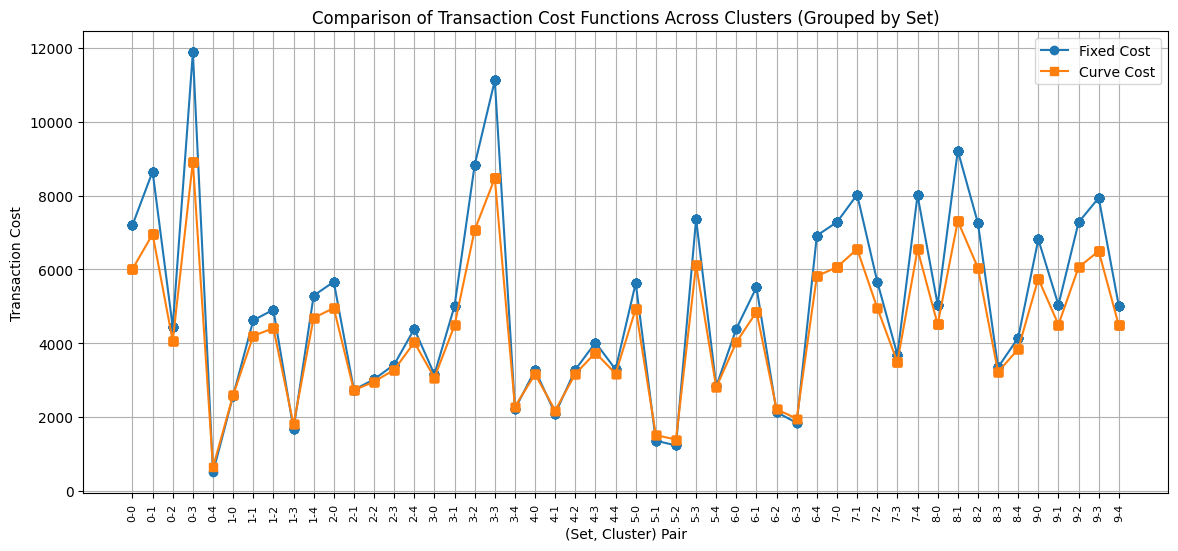

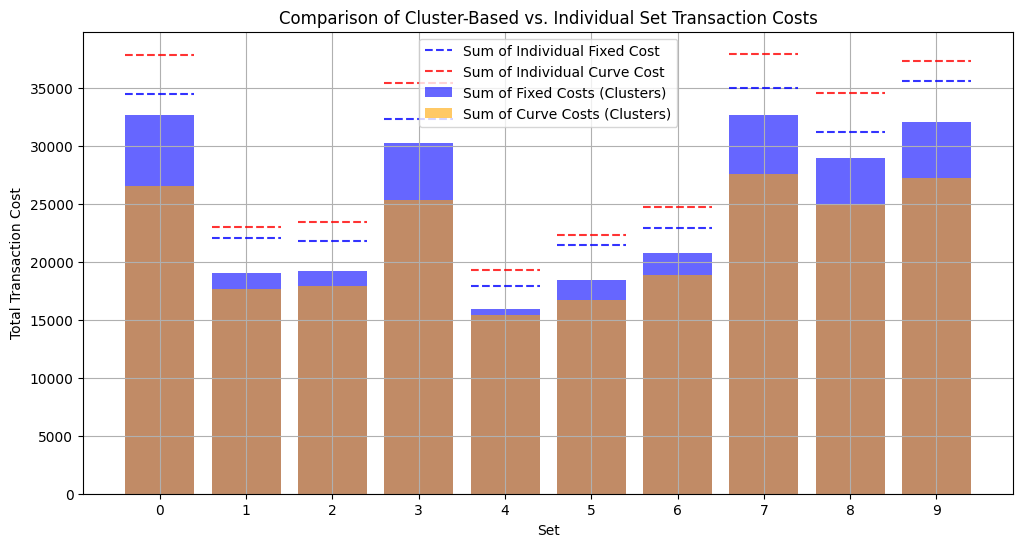

Fixed Binning Result bin_size=0.03


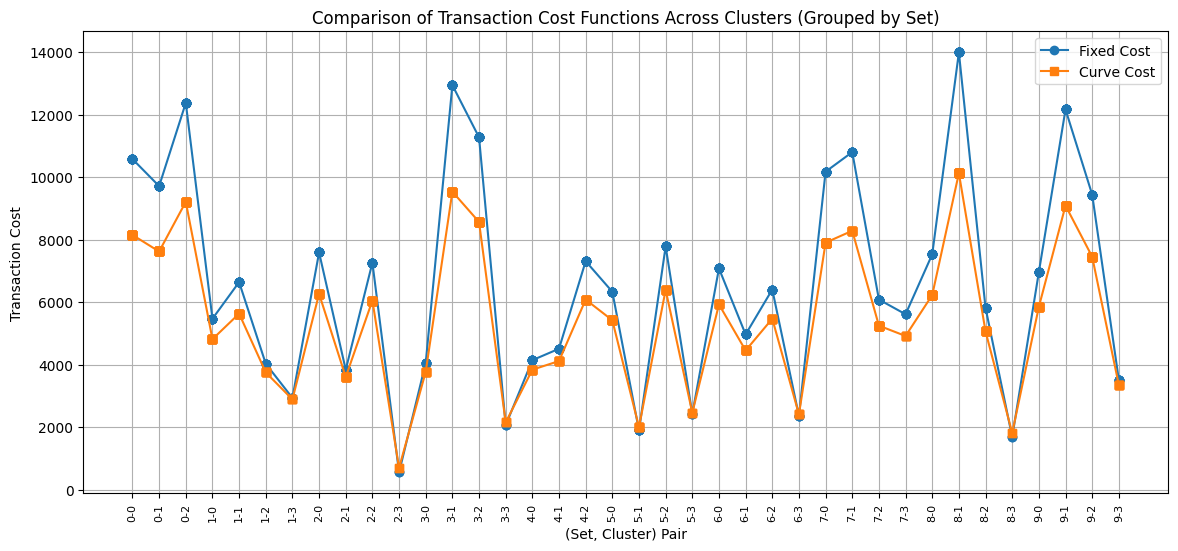

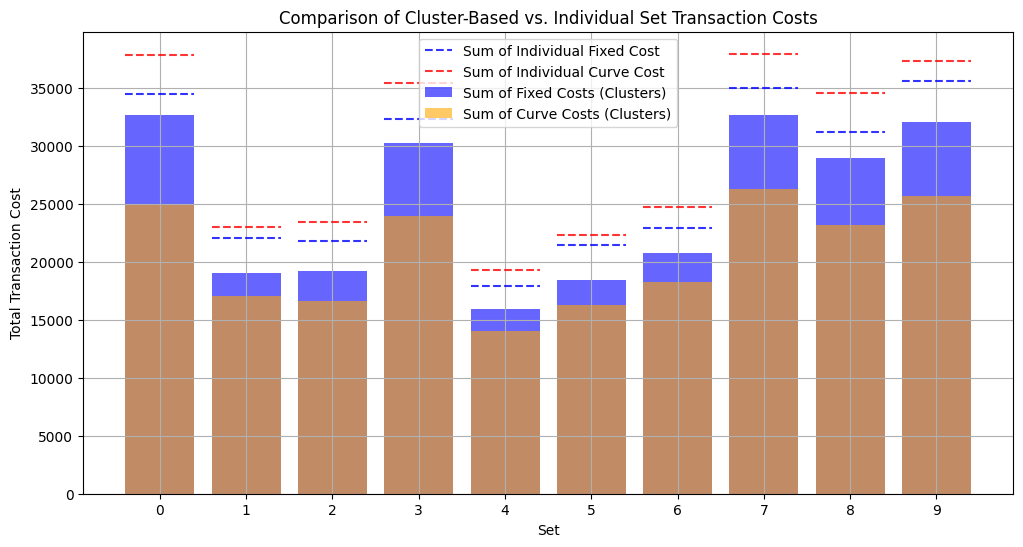

Fixed Binning Result bin_size=0.04


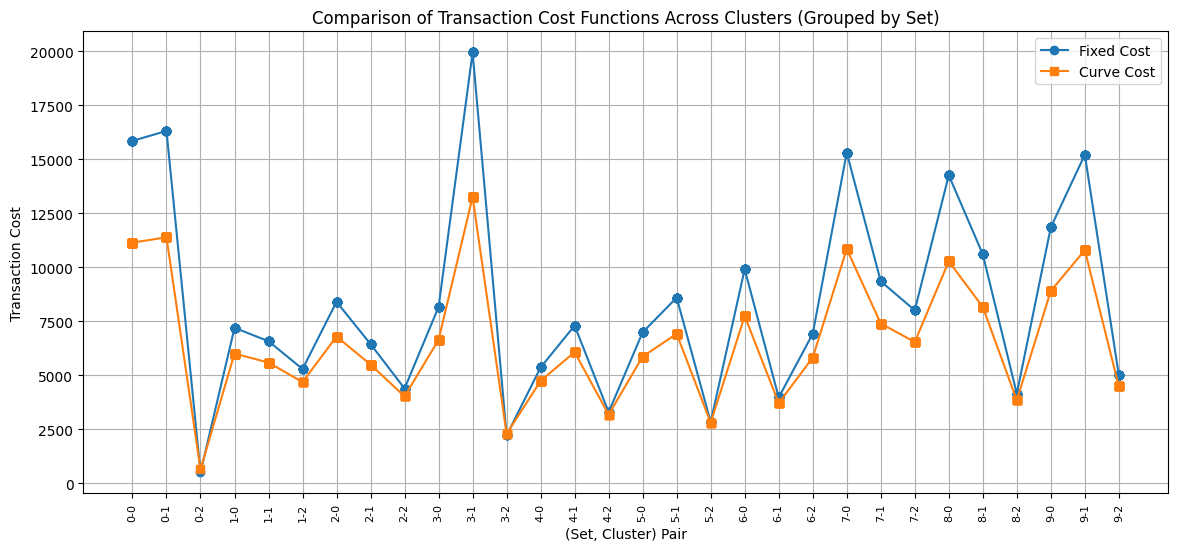

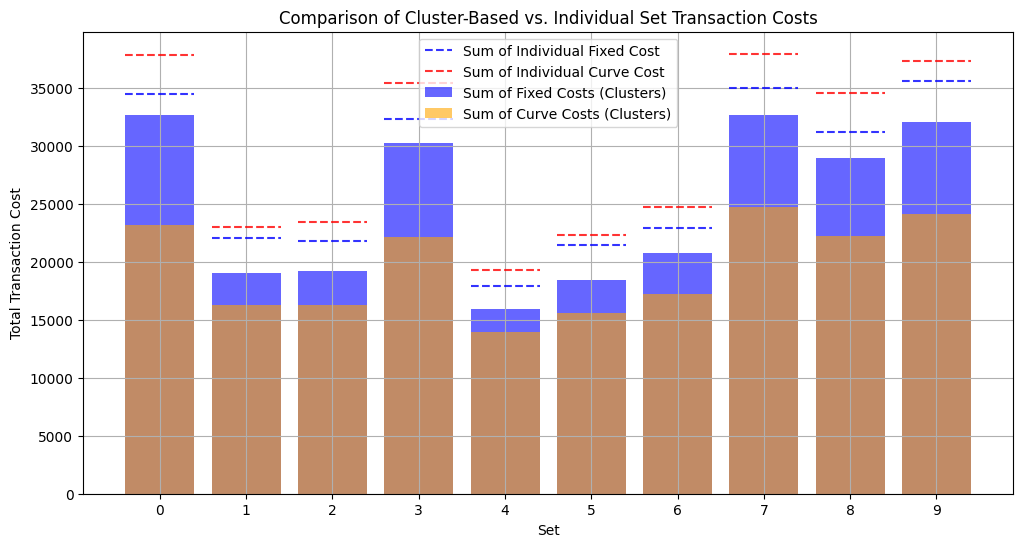

In [42]:
bin_sizes = [0.02, 0.03, 0.04]
for bin_size in bin_sizes:
    apply_fixed_binning(bin_size)

When bin size is None, each option would be its own bin and it would be the same as purchasing them individually.